In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

import time
import copy
import re

from PIL import Image
import os
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import random

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
                            roc_auc_score, confusion_matrix, classification_report, \
                            matthews_corrcoef, cohen_kappa_score, log_loss

from tqdm import tqdm


from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertTokenizer
from transformers import BertModel

In [2]:
# 완벽한 실험 재현성을 위한 랜덤제어
random_seed = 28
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed(random_seed)

In [3]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3060


# NLP and Vision Data

In [4]:
nlp_train_path = "C:/Users/ANDlab3/Desktop/multimodal/visionAndNLPmodel/data/train.csv"
nlp_val_path =  "C:/Users/ANDlab3/Desktop/multimodal/visionAndNLPmodel/data/val.csv"
nlp_test_path =  "C:/Users/ANDlab3/Desktop/multimodal/visionAndNLPmodel/data/test.csv"

# nlp_train_path = "C:/Users/ANDlab3/Desktop/VisionAndNLP/data/train.csv"
# nlp_val_path = "C:/Users/ANDlab3/Desktop/VisionAndNLP/data/val.csv"
# nlp_test_path = "C:/Users/ANDlab3/Desktop/VisionAndNLP/data/test.csv"

nlp_train_data = pd.read_csv(nlp_train_path)
nlp_val_data = pd.read_csv(nlp_val_path)
nlp_test_data = pd.read_csv(nlp_test_path)

X_train = nlp_train_data['productDisplayName']
y_train = nlp_train_data['label']

X_val = nlp_val_data['productDisplayName']
y_val = nlp_val_data['label']

X_test = nlp_test_data['productDisplayName']
y_test = nlp_test_data['label']

In [5]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [6]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [7]:
# Specify `MAX_LEN`
MAX_LEN = 30

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)
test_inputs, test_masks = preprocessing_for_bert(X_test)


# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)
test_labels = torch.tensor(y_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Tokenizing data...


C:\Users\ANDlab3\anaconda3\envs\GAN\lib\site-packages\transformers\tokenization_utils_base.py:2302: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [8]:
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(224),
        transforms.Resize(256),
        transforms.CenterCrop(224),
#         transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),    
}

image_path = "C:/Users/ANDlab3/Desktop/paper/fashion-dataset/data/"
image_datasets = {x: datasets.ImageFolder(os.path.join(image_path, x),
                                          data_transforms[x])
                  for x in ['train', 'val','test']}


dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=False, num_workers=4)
              for x in ['train', 'val','test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

class_num = len(class_names)

In [9]:
val_img_temp = []
val_img_label_temp = []
for i, j in image_datasets['val']:
    val_img_temp.append(i)
    val_img_label_temp.append(j)

In [10]:
test_img_temp = []
test_img_label_temp = []
for i, j in image_datasets['test']:
    test_img_temp.append(i)
    test_img_label_temp.append(j)

In [11]:
train_img_temp = []
train_img_label_temp = []
for i, j in image_datasets['train']:
    train_img_temp.append(i)
    train_img_label_temp.append(j)

In [12]:
train_img = torch.stack(train_img_temp, 0)
train_img_label = torch.tensor(train_img_label_temp)

val_img = torch.stack(val_img_temp, 0)
val_img_label = torch.tensor(val_img_label_temp)

test_img = torch.stack(test_img_temp, 0)
test_img_label = torch.tensor(test_img_label_temp)

In [13]:
# # For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 16

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels, train_img, train_img_label)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)


# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels, val_img, val_img_label)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)


# Create the DataLoader for our test set
test_data = TensorDataset(test_inputs, test_masks, test_labels, test_img, test_img_label)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [14]:
print(len(train_data))
print(len(val_data))
print(len(test_data))

6475
925
1850


# Vision Module

In [15]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features

#Changing the number of outputs in the last layer to the number of different item types
model_ft.fc = nn.Linear(num_ftrs, 500)
pre_model= model_ft

In [16]:
class resnet_classifier(nn.Module):
    def __init__(self, pre_model):
        super(resnet_classifier, self).__init__()
    
        D_in, H, D_out = 1000, 500, 37
        self.resnet50 = pre_model
        
        self.classifier = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(H, D_out)
        )
    
    def forward(self, image):
        outputs = self.resnet50(image)
        
        fc = self.classifier(outputs)
        
        return outputs

In [17]:
vision_module = resnet_classifier(pre_model)
vision_module.to(device)

resnet_classifier(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(

In [18]:
IMG_SAVE_PATH = "C:/Users/ANDlab3/Desktop/multimodal/visionAndNLPmodel/model/"
vision_module.load_state_dict(torch.load(IMG_SAVE_PATH+'vision_module_fine_tuned.pt'))

<All keys matched successfully>

In [19]:
# model freeze
for i, (name, param) in enumerate(vision_module.named_parameters()):
    
    param.requires_grad = False
    if i == 158:
        print('end')

end


# NLP Module

In [20]:
%%time
# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 500, 37

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.dense = nn.Sequential(
                nn.Linear(D_in, H),
        )
        
        self.classifier = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

#         # Freeze the BERT model
#         if freeze_bert:
#             for param in self.bert.parameters():
#                 param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        
        dense = self.dense(last_hidden_state_cls)
        logits = self.classifier(dense)

        return dense

Wall time: 0 ns


In [21]:
NLP_module = BertClassifier()
NLP_module= NLP_module.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [22]:
NLP_SAVE_PATH = "C:/Users/ANDlab3/Desktop/multimodal/visionAndNLPmodel/model/"
NLP_module.load_state_dict(torch.load(NLP_SAVE_PATH+'nlp_fine_tuned.pt')) # 모델 파라메타 불러오기

<All keys matched successfully>

In [23]:
# model freeze
for i, (name, param) in enumerate(NLP_module.named_parameters()):
    
    param.requires_grad = False
    if i == 198:
        print('end')

end


# LanguageAndVisionConcat

In [24]:
class LanguageAndVisionConcat(nn.Module):    
    def __init__(
        self,
        nlp_module,
        vision_module,
        num_classes,
        language_feature_dim,
        vision_feature_dim,
        fusion_output_size,
        dropout_p):
        super(LanguageAndVisionConcat, self).__init__()
        self.nlp_module = nlp_module
        self.vision_module = vision_module
        self.fusion = torch.nn.Linear(
                        in_features=(language_feature_dim + vision_feature_dim), 
                        out_features=fusion_output_size,
        )
        
        self.dropout = torch.nn.Dropout(dropout_p)
        
        self.fc = torch.nn.Linear(
            in_features=fusion_output_size, 
            out_features=num_classes
        )
        
    
    def forward(self, text, text2 , image):
        text_features = torch.nn.functional.relu(
            self.nlp_module(text, text2)
        )
        image_features = torch.nn.functional.relu(
            self.vision_module(image)
        )
        combined = torch.cat(
            [text_features, image_features], dim=1
        )
        fused = self.dropout(
            torch.nn.functional.relu(
            self.fusion(combined)
            ))
        logits = self.fc(fused)

        return logits

In [25]:
model = LanguageAndVisionConcat(
        nlp_module = NLP_module,
        vision_module = vision_module,
        num_classes = class_num,
        language_feature_dim = 500,
        vision_feature_dim = 500,
        fusion_output_size = 250,
        dropout_p = 0.5
)
model = model.to(device)
model

LanguageAndVisionConcat(
  (nlp_module): BertClassifier(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=Tru

# concat model train

In [26]:
criterion = nn.CrossEntropyLoss()

# Create the optimizer
optimizer = optim.AdamW(model.parameters(),
                  lr=5e-5,    # Default learning rate
                  eps=1e-8    # Default epsilon value
                  )

In [27]:
PATH ="C:/Users/ANDlab3/Desktop/multimodal/visionAndNLPmodel/model/"

train_loss = [] # 그래프를 그리기 위한 loss 저장용 리스트 
eval_loss = []
correct = 0
total = 0
best_acc = 0
best_epoch = 0

epoch = 35
# log_interval = 100

for epoch in range(epoch):
    time_epoch = time.time()
    
    model.train()
    running_loss = 0.0
    for data in train_dataloader:
        b_input_ids, b_attn_mask, b_labels, v_image, v_label = tuple(t.to(device) for t in data)

        optimizer.zero_grad()

        outputs = model(b_input_ids, b_attn_mask, v_image)
        loss = criterion(outputs, v_label) # 손실함수 계산
        loss.backward() # 손실함수 기준으로 역전파 선언
        
        # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
         # Update parameters and the learning rate
        optimizer.step() # 가중치 최적화 
        running_loss += loss.item()
        
    train_loss.append(running_loss / len(train_dataloader))   
    
    
    model.eval()
    with torch.no_grad():
        eval_running_loss = 0.0
        for data in val_dataloader:
            b_input_ids, b_attn_mask, b_labels, v_image, v_label = tuple(t.to(device) for t in data)

            outputs = model(b_input_ids, b_attn_mask, v_image) 
            val_loss = criterion(outputs, v_label) 
            eval_running_loss += val_loss.item()

            _, pred = torch.max(outputs, 1)

            total += v_label.size(0)

            correct += (pred == v_label).sum().item()
            acc =  (100 * correct / total)
    
        eval_loss.append(eval_running_loss / len(val_dataloader)) 
        
        time_elapsed = time.time() - time_epoch
        
        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), PATH+'best_model.pt')
            best_epoch = epoch+1
        
        print('[%d] Train loss: %.3f' %(epoch + 1, running_loss / len(train_dataloader))
     ,' val loss: %.3f' %(eval_running_loss / len(val_dataloader))
     ,'Acc:', round(acc,2) ,'time_elapsed:', round(time_elapsed),'second')
        
print('Accuracy of the network on the val images: %d %%' % (100 * correct / total))
print('Best epoch:', best_epoch, 'Best Acc:', round(best_acc, 2))

[1] Train loss: 1.961  val loss: 0.471 Acc: 96.97 time_elapsed: 28 second
[2] Train loss: 0.316  val loss: 0.106 Acc: 97.41 time_elapsed: 27 second
[3] Train loss: 0.109  val loss: 0.083 Acc: 97.33 time_elapsed: 27 second
[4] Train loss: 0.074  val loss: 0.069 Acc: 97.43 time_elapsed: 27 second
[5] Train loss: 0.061  val loss: 0.069 Acc: 97.45 time_elapsed: 27 second
[6] Train loss: 0.052  val loss: 0.068 Acc: 97.51 time_elapsed: 27 second
[7] Train loss: 0.051  val loss: 0.070 Acc: 97.54 time_elapsed: 27 second
[8] Train loss: 0.048  val loss: 0.070 Acc: 97.57 time_elapsed: 27 second
[9] Train loss: 0.047  val loss: 0.071 Acc: 97.62 time_elapsed: 27 second
[10] Train loss: 0.045  val loss: 0.075 Acc: 97.64 time_elapsed: 27 second
[11] Train loss: 0.045  val loss: 0.072 Acc: 97.66 time_elapsed: 27 second
[12] Train loss: 0.043  val loss: 0.064 Acc: 97.66 time_elapsed: 27 second
[13] Train loss: 0.041  val loss: 0.075 Acc: 97.67 time_elapsed: 27 second
[14] Train loss: 0.041  val loss: 

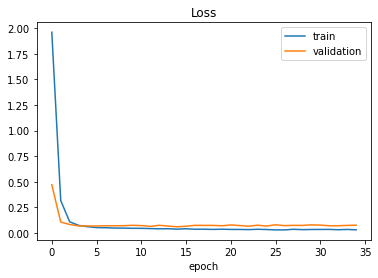

In [28]:
plt.plot(train_loss)
plt.plot(eval_loss)
plt.legend(['train','validation'])
plt.title("Loss")
plt.xlabel("epoch")
plt.show()